# Load Libraris and Data

In [15]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import re

In [16]:
twitter_data = pd.read_csv(r"../data/scored_tweets_total.csv")

# Creating Digraph

To show the number of time someone is being mentioned

In [64]:
import networkx as nx
import re

def extract_mentions(text):
    if isinstance(text, str):
        return re.findall(r'@(\w+)', text)
    return []

G = nx.DiGraph()

# Add all users as nodes
for screen_name in twitter_data['user.screen_name'].unique():
    G.add_node(screen_name)

# Add edges based on mentions
for index, row in twitter_data.iterrows():
    sender = row['user.screen_name']
    mentions = extract_mentions(row['text'])
    for mentioned in mentions:
        # Mentioned handle not in the dataset
        if mentioned not in np.unique(twitter_data["user.screen_name"]):
            continue
        if G.has_edge(sender, mentioned):
            G[sender][mentioned]['weight'] += 1
        else:
            G.add_edge(sender, mentioned, weight=1)

# Add node attributes (pumper status)
for index, row in twitter_data.iterrows():
    G.nodes[row['user.screen_name']]['pumper'] = row['Known_Pumper']

# Print the graph
print(G.edges(data=True))
print(G.nodes(data=True))

[('UCitnow', 'UCitnow', {'weight': 3}), ('UCitnow', 'ShortSqueezed1', {'weight': 2}), ('christinebarnum', 'GetScanz', {'weight': 1}), ('christinebarnum', 'BrandonKodallas', {'weight': 1}), ('CharlesMorriz', 'GetScanz', {'weight': 1}), ('CharlesMorriz', 'JoeDTrader', {'weight': 1}), ('CharlesMorriz', 'Candy_OTC', {'weight': 1}), ('CharlesMorriz', 'AlexDelarge6553', {'weight': 1}), ('jehause', 'Kelvin_OTC', {'weight': 1}), ('jehause', 'allfacnocap', {'weight': 1}), ('HiegerBrian', 'jehause', {'weight': 1}), ('soupbone1965', 'jehause', {'weight': 1}), ('soupbone1965', 'Glenn12399', {'weight': 1}), ('soupbone1965', 'TTrader1976', {'weight': 1}), ('soupbone1965', 'EEENF_ARMY', {'weight': 2}), ('LeifBierer', 'jehause', {'weight': 3}), ('LeifBierer', 'GeniusTrader777', {'weight': 1}), ('LeifBierer', 'splendira', {'weight': 1}), ('LeifBierer', 'Ninja1Stock', {'weight': 1}), ('DaveWhitman12', 'jehause', {'weight': 1}), ('DaveWhitman12', 'PremiumCashFlow', {'weight': 3}), ('DaveWhitman12', 'dayo

# Get Network Metrics and pumper connectivity

In [65]:
# Calculate network features
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
eigenvector_centrality = nx.eigenvector_centrality(G)
pagerank = nx.pagerank(G)

# Add centrality measures as node attributes
for node in G.nodes():
    G.nodes[node]['degree_centrality'] = degree_centrality[node]
    G.nodes[node]['betweenness_centrality'] = betweenness_centrality[node]
    G.nodes[node]['eigenvector_centrality'] = eigenvector_centrality[node]
    G.nodes[node]['pagerank'] = pagerank[node]

# Calculate mention counts
mention_counts = {}
for node in G.nodes():
    mention_counts[node] = {
        'mentions_sent': len([edge for edge in G.out_edges(node)]),
        'mentions_received': len([edge for edge in G.in_edges(node)])
    }

# Add mention counts as node attributes
for node in G.nodes():
    G.nodes[node]['mentions_sent'] = mention_counts[node]['mentions_sent']
    G.nodes[node]['mentions_received'] = mention_counts[node]['mentions_received']

# Calculate pumper connection ratio
for node in G.nodes():
    pumper_count = 0
    neighbor_count = 0
    for neighbor in G.neighbors(node):
        neighbor_count += 1
        if 'pumper' in G.nodes[neighbor]:
            if G.nodes[neighbor]['pumper'] == 1:
                pumper_count += 1
        else:
            print(f"Warning: Node '{neighbor}' has no 'pumper' attribute.")
    if G.nodes[node]['pumper']:
        G.nodes[node]['pumper_ratio'] = 1
    elif neighbor_count > 0:
        G.nodes[node]['pumper_ratio'] = pumper_count / neighbor_count
    else:
        G.nodes[node]['pumper_ratio'] = 0

In [71]:
# Create feature matrix
node_features = []
node_labels = []
node_names = []
for node in G.nodes():
    node_features.append([
        G.nodes[node]['degree_centrality'],
        G.nodes[node]['betweenness_centrality'],
        G.nodes[node]['eigenvector_centrality'],
        G.nodes[node]['pagerank']
    ])
    node_labels.append(G.nodes[node]['pumper'])
    node_names.append(node)

feature_df = pd.DataFrame(node_features, columns=[
    'degree_centrality',
    'betweenness_centrality',
    'eigenvector_centrality',
    'pagerank'
])
target_series = pd.Series(node_labels)
name_series = pd.Series(node_names)

In [72]:
density = nx.density(G)
print(f"Graph density: {density}")

Graph density: 0.00033683468711034317


Damn Sparse

In [73]:
print(feature_df)

      degree_centrality  betweenness_centrality  eigenvector_centrality  \
0              0.000826                0.000000            1.224147e-12   
1              0.000000                0.000000            1.167437e-18   
2              0.001927                0.000000            2.695172e-03   
3              0.002202                0.000243            1.455844e-02   
4              0.001101                0.000000            1.167437e-18   
...                 ...                     ...                     ...   
3629           0.000275                0.000000            1.167437e-18   
3630           0.000275                0.000000            1.167437e-18   
3631           0.000275                0.000000            1.167437e-18   
3632           0.000000                0.000000            1.167437e-18   
3633           0.000275                0.000000            1.167437e-18   

      pagerank  
0     0.000208  
1     0.000102  
2     0.000611  
3     0.000446  
4     0.000102

# Model Training to get User Probability

In [74]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

# Modified User Probability Calculation
node_features = []
node_labels = []
node_names = []
for node in G.nodes():
    node_features.append([
        G.nodes[node]['degree_centrality'],
        G.nodes[node]['pumper_ratio'],
        G.nodes[node]['mentions_sent'],
        G.nodes[node]['mentions_received'],
        G.nodes[node]['betweenness_centrality'],
        G.nodes[node]['eigenvector_centrality'],
    ])
    if 'pumper' in G.nodes[node]:
        node_labels.append(G.nodes[node]['pumper'])
    else:
        node_labels.append(np.nan)
    node_names.append(node)

feature_df = pd.DataFrame(node_features, columns=[
    'degree_centrality',
    'pumper_ratio',
    "mentions_sent",
    "mentions_received",
    "betweenness_centrality",  "eigenvector_centrality"
])
target_series = pd.Series(node_labels)
name_series = pd.Series(node_names)

not_nan_index = target_series.notna()
feature_df = feature_df[not_nan_index]
target_series = target_series[not_nan_index]
name_series = name_series[not_nan_index]

X_train, X_test, y_train, y_test, names_train, names_test = train_test_split(
    feature_df, target_series, name_series, test_size=0.2, random_state=42
)

model = LogisticRegression()
model.fit(X_train, y_train)

probabilities = model.predict_proba(X_test)[:, 1]

user_pumper_probabilities = {}
predicted_probability = []
count = 0
for i, user in enumerate(names_test):
    if user in G.nodes() and 'pumper' in G.nodes[user] and G.nodes[user]['pumper'] == 1:
        predicted_probability.append(probabilities[i])
        user_pumper_probabilities[user] = max(0.8, probabilities[i])  # Strong prior
        count += 1
    else:
        user_pumper_probabilities[user] = probabilities[i]

8
9


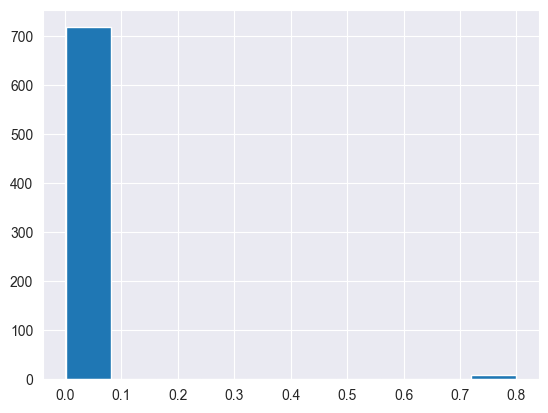

In [75]:
import matplotlib.pyplot as plt
print(count)
print(sum(np.array(list(user_pumper_probabilities.values())) > 0.5))
plt.hist(user_pumper_probabilities.values())
plt.show()

There is 1 extra user that has a chance of being a pumper

In [31]:
density = nx.density(G)
print(f"Graph density: {density}")

Graph density: 0.00033683468711034317


# Using Tweet to train model

In [33]:
twitter_data['user_pumper_probability'] = twitter_data['user.screen_name'].map(user_pumper_probabilities)
# Calculate the mean of the 'user_pumper_probability' column
mean_pumper_probability = twitter_data['user_pumper_probability'].mean()
# Fill NaN values with the mean
twitter_data['user_pumper_probability'] = twitter_data['user_pumper_probability'].fillna(mean_pumper_probability)

In [34]:
def adjust_pumper_probabilities(df, known_pumper_col='Known_Pumper', probability_col='user_pumper_probability'):
    """
    Iterates through the DataFrame and sets user_pumper_probability to 0.8
    if Known_Pumper is 1 (or '1') and the probability is less than 0.5.

    Args:
        df (pd.DataFrame): The DataFrame containing your Twitter data.
        known_pumper_col (str): The name of the column indicating known pumpers.
        probability_col (str): The name of the column to set the probability.

    Returns:
        pd.DataFrame: The modified DataFrame.
    """

    df_copy = df.copy()

    # Handle both integer and string '1' for Known_Pumper
    known_pumper_mask = (df_copy[known_pumper_col] == 1) | (df_copy[known_pumper_col] == '1')

    # Create a mask for probabilities less than 0.5
    low_probability_mask = df_copy[probability_col] < 0.5

    # Combine the masks using logical AND
    combined_mask = known_pumper_mask & low_probability_mask

    # Set probabilities to 0.8 where both conditions are met
    df_copy.loc[combined_mask, probability_col] = 0.8

    return df_copy

twitter_data = adjust_pumper_probabilities(twitter_data)

360
363
4.94986655919546


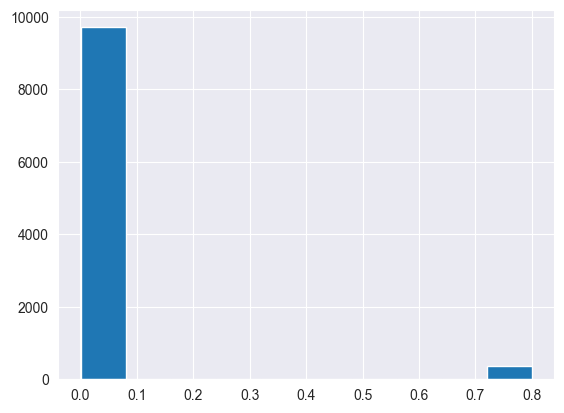

In [77]:
from scipy.stats import skew
print(sum(twitter_data['Known_Pumper']))
print(sum(twitter_data['user_pumper_probability'] > 0.6))
print(skew(twitter_data['user_pumper_probability']))
plt.hist(twitter_data['user_pumper_probability'])
plt.show()

In [85]:
twitter_data[(twitter_data['user_pumper_probability'] > 0.6) & (twitter_data['user_pumper_probability'] < 0.8)]

,Stock,Datetime,user.screen_name,id_str,text,Sentiment,Known_Pumper,Price_Region,Inflection_Point,user_pumper_probability,binned_probability
744,SOL,2021-03-28 11:17:38+00:00,saamon2500,1376131362546065409a,$SOL ATH🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀,1,0,1.0,NaN,0.656745,1
758,SOL,2021-03-28 02:05:42+00:00,saamon2500,1375992460812316674a,$SOL 祝17ドル復帰。\n枚数ゴリゴリ増やしたんでATHカモン🚀\n\nIDO期待あげだ...,1,0,1.0,NaN,0.656745,1
1054,SOL,2021-03-28 11:48:02+00:00,saamon2500,1376139010863603712a,フォロワー7000人感謝🙏 $SOL ATH記念‼️サーモンが注目してるアルトコイン $SO...,1,0,1.0,NaN,0.656745,1


In [37]:
# Save Data
# twitter_data.to_csv(r"C:\Users\limti\PycharmProjects\DSA4263_StockTweets\data\scored_tweets_with_probabilities.csv", index=False)

## Do stratified split to keep a portion of the dataset to do treshold tuning

In [119]:
import pandas as pd
import re
import emoji

twitter_data = pd.read_csv(r"../data/scored_tweets_with_probabilities.csv")

def count_hashtags(text):
    return len(re.findall(r'#\w+', text))

def count_emojis(text):
    return len([c for c in text if c in emoji.EMOJI_DATA])

def count_keywords(text):
    keywords = [
        'pump', 'dump', 'bullish', 'bearish', 'to the moon', 'short squeeze', 'hold', 'buy', 'sell',
        'rocket', 'moonshot', 'gains', 'profit', 'stock tip', 'insider info', 'guaranteed profits',
        'easy money', 'get rich quick', 'massive gains', 'skyrocket', 'explode', 'surge', 'rally',
        'squeeze', 'diamond hands', 'ape in', 'yolo', 'fomo', 'bagholder', 'bag holders',
        'squeeze play', 'market manipulation', 'hype', 'hype train', 'hot stock', 'next big thing',
        'get in now', 'before it\'s too late', 'don\'t miss out', 'limited time offer',
        'secret tip', 'insider trading', 'whale alert', 'breakout', 'uptrend', 'downtrend',
        'price target', 'PT', 'shares', 'calls', 'puts', 'options', 'leverage', 'margin',
        'DD', 'due diligence', 'fundamentals', 'technical analysis', 'TA', 'chart', 'volume',
        '10x', '100x', '1000x', 'millionaire', 'billionaire', 'tendies', 'stonks',
        'meme stock', 'penny stock', 'low float', 'OTC', 'over the counter',
        'insane gains', 'major catalyst', 'catalyst', 'breakout imminent', 'buy the dip',
        'diamond hands', 'paper hands', 'long term hold', 'squeeze it', 'squeeze em',
        'pamp it', 'pumping', 'dumping', 'bagholding', 'moon', 'rocket ship',
        'squeeze it', 'squeeze em', 'pamp it', 'pumping', 'dumping', 'bagholding', 'moon', 'rocket ship',
        'get in', 'get out', 'take profit', 'stop loss', 'limit order', 'market order', 'stop order'
    ]
    count = 0
    for keyword in keywords:
        count += len(re.findall(r'\b' + re.escape(keyword) + r'\b', text.lower()))
    return count

def count_dollar_capital_tickers(text):
    """Counts dollar signs followed by capitalized letters of length > 3."""
    return len(re.findall(r'\$([A-Z]{4,})\b', text))

def count_url_mentions(text):
    return len(re.findall(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', text))

# Apply the new functions
twitter_data['hashtag_count'] = twitter_data['text'].apply(count_hashtags)
twitter_data['emoji_count'] = twitter_data['text'].apply(count_emojis)
twitter_data['keyword_count'] = twitter_data['text'].apply(count_keywords)
twitter_data['stock_ticker_count'] = twitter_data['text'].apply(count_dollar_capital_tickers)
twitter_data['url_count'] = twitter_data['text'].apply(count_url_mentions)

# Display the first few rows to verify the new columns
twitter_data['pumper_category'] = (twitter_data['user_pumper_probability'] > 0.5).astype(int)

In [125]:
import pandas as pd
import re
import emoji
from deep_translator import GoogleTranslator
from langdetect import detect

def remove_emojis(text):
    """Removes emojis from text."""
    return ''.join(c for c in text if c not in emoji.EMOJI_DATA)

def translate_non_english(text, target_language='en'):
    """Detects non-English text and translates it using deep-translator."""
    try:
        cleaned_text = remove_emojis(text)
        source_language = detect(cleaned_text)
        if source_language != target_language:
            translated_text = GoogleTranslator(source='auto', target=target_language).translate(cleaned_text)
            return translated_text
        else:
            return text  # No translation needed
    except Exception as e:
        print(f"Translation Error: {e}")
        return text  # Return original text on error

def count_dollar_capital_tickers(text):
    """Counts dollar signs followed by capitalized letters of length > 3."""
    return len(re.findall(r'\$([A-Z]{4,})\b', text))

def process_text_column(df_1, text_column='text'):
    """Removes emojis, translates non-English text, and counts dollar capital tickers."""
    df = df_1.copy()
    df[text_column] = df[text_column].apply(remove_emojis)
    df[text_column] = df[text_column].apply(translate_non_english)
    return df

In [126]:
twitter_data_translated = process_text_column(twitter_data)

In [129]:
twitter_data_translated.to_csv(r"../data/scored_tweets_final_translated.csv", index=False)

In [128]:
twitter_data_translated[(twitter_data_translated["user_pumper_probability"] > 0.6) & (twitter_data_translated["user_pumper_probability"] <0.8)]

,Stock,Datetime,user.screen_name,id_str,text,Sentiment,Known_Pumper,Price_Region,Inflection_Point,user_pumper_probability,hashtag_count,emoji_count,keyword_count,stock_ticker_count,url_count,pumper_category
744,SOL,2021-03-28 11:17:38+00:00,saamon2500,1376131362546065409a,$SOL ATH,1,0,1.0,NaN,0.656745,0,22,0,0,0,1
758,SOL,2021-03-28 02:05:42+00:00,saamon2500,1375992460812316674a,$SOL Congratulations to return to $17.\nI've i...,1,0,1.0,NaN,0.656745,0,2,0,0,2,1
1054,SOL,2021-03-28 11:48:02+00:00,saamon2500,1376139010863603712a,"Thank you to 7,000 followers $SOL ATH commemor...",1,0,1.0,NaN,0.656745,1,4,0,0,1,1


In [130]:
twitter_data_translated

,Stock,Datetime,user.screen_name,id_str,text,Sentiment,Known_Pumper,Price_Region,Inflection_Point,user_pumper_probability,hashtag_count,emoji_count,keyword_count,stock_ticker_count,url_count,pumper_category
0,AXTG,2021-03-25 17:50:13+00:00,UCitnow,1375142994920271872a,#RT @ldev117: RT @UCitnow: @ShortSqueezed1 @EV...,0,0,1.0,NaN,0.006720,1,0,0,1,1,0
1,AXTG,2021-03-25 17:50:48+00:00,UCitnow,1375143141058080768a,RT @UCitnow: #RT @ldev117: RT @UCitnow: @Short...,0,0,1.0,NaN,0.006720,1,0,0,1,1,0
2,AXTG,2021-03-25 18:47:48+00:00,Rad7RR,1375157484063584261a,$AXTG Big OTC % Gainer!,1,0,1.0,NaN,0.025278,0,3,0,1,0,0
3,AXTG,2021-03-25 20:02:03+00:00,GetScanz,1375176172099747845a,Today’s Top Penny Stock Gainers\n\n$LTTGF $AXT...,1,0,1.0,NaN,0.025278,1,0,1,9,1,0
4,AXTG,2021-03-25 20:02:48+00:00,christinebarnum,1375176361560604679a,RT @GetScanz: Today’s Top Penny Stock Gainers\...,1,0,1.0,NaN,0.025278,3,0,1,9,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10071,EEENF,2021-04-09 01:00:55+00:00,TVTVentures,1380324815689539585a,Holding until at least summer $WDHR $EEENF $PH...,1,0,0.0,NaN,0.025278,0,4,0,5,0,0
10072,EEENF,2021-04-09 01:06:47+00:00,BuyLowSell420,1380326289735708672a,@TheFlyingScotto Yep well now that the bushy a...,-1,0,0.0,NaN,0.025278,0,0,0,0,1,0
10073,EEENF,2021-04-09 01:06:56+00:00,superlars34,1380326328524623873a,$VPER $PHIL $IMTL $ABML $UATG $SFOR $LTNC $IN...,1,0,0.0,NaN,0.025278,0,1,0,15,1,0
10074,EEENF,2021-04-09 01:07:55+00:00,DaveWhitman12,1380326575414120448a,RT @Jasontrade99: $ eeenf,1,0,0.0,NaN,0.025278,0,17,0,1,0,0


In [46]:
import pandas as pd
import re
import emoji
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MaxAbsScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
import spacy
from transformers import pipeline
import subprocess


def count_hashtags(text):
    return len(re.findall(r'#\w+', text))

def count_emojis(text):
    return len([c for c in text if c in emoji.EMOJI_DATA])

def preprocess_text(text):
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#\w+', '', text)
    text = ''.join(c for c in text if c not in emoji.EMOJI_DATA)
    text = re.sub(r'[^\w\s]', '', text)
    text = text.lower()
    return text

def count_keywords(text):
    keywords = [
        'pump', 'dump', 'bullish', 'bearish', 'to the moon', 'short squeeze', 'hold', 'buy', 'sell',
        'rocket', 'moonshot', 'gains', 'profit', 'stock tip', 'insider info', 'guaranteed profits',
        'easy money', 'get rich quick', 'massive gains', 'skyrocket', 'explode', 'surge', 'rally',
        'squeeze', 'diamond hands', 'ape in', 'yolo', 'fomo', 'bagholder', 'bag holders',
        'squeeze play', 'market manipulation', 'hype', 'hype train', 'hot stock', 'next big thing',
        'get in now', 'before it\'s too late', 'don\'t miss out', 'limited time offer',
        'secret tip', 'insider trading', 'whale alert', 'breakout', 'uptrend', 'downtrend',
        'price target', 'PT', 'shares', 'calls', 'puts', 'options', 'leverage', 'margin',
        'DD', 'due diligence', 'fundamentals', 'technical analysis', 'TA', 'chart', 'volume',
        '10x', '100x', '1000x', 'millionaire', 'billionaire', 'tendies', 'stonks',
        'meme stock', 'penny stock', 'low float', 'OTC', 'over the counter',
        'insane gains', 'major catalyst', 'catalyst', 'breakout imminent', 'buy the dip',
        'diamond hands', 'paper hands', 'long term hold', 'squeeze it', 'squeeze em',
        'pamp it', 'pumping', 'dumping', 'bagholding', 'moon', 'rocket ship',
        'squeeze it', 'squeeze em', 'pamp it', 'pumping', 'dumping', 'bagholding', 'moon', 'rocket ship',
        'get in', 'get out', 'take profit', 'stop loss', 'limit order', 'market order', 'stop order'
    ]
    count = 0
    for keyword in keywords:
        count += len(re.findall(r'\b' + re.escape(keyword) + r'\b', text.lower()))
    return count

def align_tfidf_columns(train_df, test_df):
    train_cols = set(train_df.columns)
    test_cols = set(test_df.columns)
    missing_train = test_cols - train_cols
    missing_test = train_cols - test_cols
    for col in missing_train:
        train_df[col] = 0
    for col in missing_test:
        test_df[col] = 0
    return train_df[sorted(train_cols.intersection(test_cols))], test_df[sorted(train_cols.intersection(test_cols))]


def create_ml_pipeline_with_tfidf_regression_domain(df_1, regressor, text_column='text', target_column='user_pumper_probability', numerical_columns=["emoji_count", "hashtag_count", "keyword_count"], max_tfidf_features=200, param_grid=None):
    df = df_1.copy()
    df = df[[text_column, target_column]]
    df['hashtag_count'] = df[text_column].apply(count_hashtags)
    df['emoji_count'] = df[text_column].apply(count_emojis)
    df['keyword_count'] = df[text_column].apply(count_keywords)
    df[text_column] = df[text_column].apply(preprocess_text)

    X = df.drop(target_column, axis=1)
    #add sentiment data to numerical columns
    numerical_columns = list(set(numerical_columns))
    y = df[target_column]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=69)

    y_train_transformed = np.log(y_train + 1e-6)
    y_test_transformed = np.log(y_test + 1e-6)

    vectorizer = TfidfVectorizer(max_features=max_tfidf_features, stop_words='english', ngram_range=(1, 2))
    train_tfidf_matrix = vectorizer.fit_transform(X_train[text_column])
    test_tfidf_matrix = vectorizer.transform(X_test[text_column])

    train_tfidf_df = pd.DataFrame(train_tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())
    test_tfidf_df = pd.DataFrame(test_tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

    train_tfidf_df, test_tfidf_df = align_tfidf_columns(train_tfidf_df, test_tfidf_df)

    X_train = X_train.reset_index(drop=True)
    train_tfidf_df = train_tfidf_df.reset_index(drop=True)
    X_test = X_test.reset_index(drop=True)
    test_tfidf_df = test_tfidf_df.reset_index(drop=True)

    X_train = pd.concat([X_train.drop(['text'], axis=1), train_tfidf_df], axis=1)
    X_test = pd.concat([X_test.drop(['text'], axis=1), test_tfidf_df], axis=1)

    tfidf_columns = [col for col in X_train.columns if col not in numerical_columns and col != 'hashtag_count' and col != 'emoji_count']

    numeric_tfidf_columns = [col for col in tfidf_columns if pd.api.types.is_numeric_dtype(X_train[col])]
    tfidf_columns = numeric_tfidf_columns

    imputer = SimpleImputer(strategy='mean')
    X_train[numerical_columns] = imputer.fit_transform(X_train[numerical_columns])
    X_test[numerical_columns] = imputer.transform(X_test[numerical_columns])

    X_train[tfidf_columns] = imputer.fit_transform(X_train[tfidf_columns])
    X_test[tfidf_columns] = imputer.transform(X_test[tfidf_columns])

    X_train_final = pd.concat([X_train[numerical_columns].reset_index(drop=True), X_train[tfidf_columns].reset_index(drop=True)], axis=1)
    X_test_final = pd.concat([X_test[numerical_columns].reset_index(drop=True), X_test[tfidf_columns].reset_index(drop=True)], axis=1)

    preprocessor = ColumnTransformer(
        transformers=[
            ('numerical', 'passthrough', numerical_columns),
            ('tfidf', Pipeline([('pca', PCA(n_components=0.95)), ('scaler', MaxAbsScaler())]), tfidf_columns),
        ],
        remainder='drop'
    )

    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', regressor)
    ])

    sample_weights = np.where(y_train > 0.5, 100.0, 1.0)

    if param_grid is not None:
        grid_search = GridSearchCV(
            pipeline,
            param_grid=param_grid,
            cv=3,
            scoring='r2',
            verbose=2,
            n_jobs=-1,
        )

        try:
            grid_search.fit(X_train_final, y_train_transformed, regressor__sample_weight=sample_weights)
            pipeline = grid_search.best_estimator_
        except Exception as e:
            print(f"Error during model tuning: {e}")
            return None, vectorizer, None, None

    else:
        pipeline.fit(X_train_final, y_train_transformed, regressor__sample_weight=sample_weights)

    y_train_pred_transformed = pipeline.predict(X_train_final)
    y_test_pred_transformed = pipeline.predict(X_test_final)

    y_train_pred = np.exp(y_train_pred_transformed) - 1e-6
    y_test_pred = np.exp(y_test_pred_transformed) - 1e-6

    train_metrics = {
        'mse': mean_squared_error(y_train, y_train_pred),
        'mae': mean_absolute_error(y_train, y_train_pred),
        'r2': r2_score(y_train, y_train_pred)
    }

    test_metrics = {
        'mse': mean_squared_error(y_test, y_test_pred),
        'mae': mean_absolute_error(y_test, y_test_pred),
        'r2': r2_score(y_test, y_test_pred)
    }

    return pipeline, vectorizer, train_metrics, test_metrics

In [47]:
import joblib
def train_and_save_model(df, model, pipeline_filename, vectorizer_filename, param_grid=None):
    """
    Trains a regression model, saves the pipeline and vectorizer to separate files.
    """
    pipeline, vectorizer, train_metrics, test_metrics = create_ml_pipeline_with_tfidf_regression_domain(
        df_1=df,
        regressor=model,
        param_grid=param_grid,
        max_tfidf_features=200
    )
    joblib.dump(pipeline, pipeline_filename)  # Save the pipeline
    joblib.dump(vectorizer, vectorizer_filename) # Save the vectorizer

    print(f"Pipeline saved to: {pipeline_filename}")
    print(f"Vectorizer saved to: {vectorizer_filename}")
    print("Train Metrics:", train_metrics)
    print("Test Metrics:", test_metrics)

In [48]:
import pandas as pd
import re
import emoji
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.impute import SimpleImputer
import joblib
from tf_idf_new import PumpDetection
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
def tune_threshold(df, model_name, model_info, threshold_value = 0.7):
    pipeline_path = model_info["pipeline_filename"]
    vectorizer_path = model_info["vectorizer_filename"]
    detector = PumpDetection(pipeline_path, vectorizer_path)
    actual = np.array(df["user_pumper_probability"])
    predicted = np.array(detector.predict(df["text"]))
    #plt.plot(actual-predicted, label="Error")
    #plt.show()
    actual_cat = (actual > threshold_value).astype(int)
    predicted_cat = (predicted > threshold_value).astype(int)

    result = {
        "model": model_name,
        "accuracy": accuracy_score(actual_cat, predicted_cat),
        "precision": precision_score(actual_cat, predicted_cat),
        "recall": recall_score(actual_cat, predicted_cat),
        "f1": f1_score(actual_cat, predicted_cat),
        "confusion_matrix": confusion_matrix(actual_cat, predicted_cat)
    }
    
    return result

## Simple model

In [49]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.svm import SVR
model_data = {
    "ridge_regression": {
        "model": Ridge(),
        "param_grid": {
            'regressor__alpha': [0.1, 1.0, 10.0],
        },
        "pipeline_filename": r"model/ridge_regression_pipeline.joblib",
        "vectorizer_filename": r"model/ridge_regression_vectorizer.joblib"
    },
     "lasso_regression": {
        "model": Lasso(),
        "param_grid": {
            'regressor__alpha': [0.1, 1.0, 10.0],
        },
        "pipeline_filename": r"model/lasso_regression_pipeline.joblib",
        "vectorizer_filename": r"model/lasso_regression_vectorizer.joblib"
    },
    "svr": {
        "model": SVR(),
        "param_grid": {
            'regressor__C': [0.1, 1.0, 10.0],
            'regressor__kernel': ['linear', 'rbf'],
            'regressor__epsilon': [0.1, 0.2, 0.3],
        },
        "pipeline_filename": r"model/svr_pipeline.joblib",
        "vectorizer_filename": r"model/svr_vectorizer.joblib"
    },
}

In [50]:
for model_name, model_info in model_data.items():
    print(f"Training {model_name}...")
    train_and_save_model(
        df=train_data,
        model=model_info["model"],
        pipeline_filename=model_info["pipeline_filename"],
        vectorizer_filename=model_info["vectorizer_filename"],
        param_grid=model_info["param_grid"]
    )

Training ridge_regression...
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Pipeline saved to: model/ridge_regression_pipeline.joblib
Vectorizer saved to: model/ridge_regression_vectorizer.joblib
Train Metrics: {'mse': 0.07940121692952963, 'mae': 0.17134779634465283, 'r2': -2.9021797907686686}
Test Metrics: {'mse': 0.08975569517230648, 'mae': 0.18578578297676285, 'r2': -2.6500781375030993}
Training lasso_regression...
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Pipeline saved to: model/lasso_regression_pipeline.joblib
Vectorizer saved to: model/lasso_regression_vectorizer.joblib
Train Metrics: {'mse': 0.08492708159960634, 'mae': 0.2561339456247704, 'r2': -3.173748896078899}
Test Metrics: {'mse': 0.08755121696961303, 'mae': 0.26209692112916894, 'r2': -2.5604290330445316}
Training svr...
Fitting 3 folds for each of 18 candidates, totalling 54 fits


KeyboardInterrupt: 

Ridge regression perform the best, time to test the treshold

In [47]:
thresholds = np.arange(0.02, 0.03, 0.001)
for threshold in thresholds:
    print(f"Threshold: {round(threshold,3)}")
    model_name = "svr"
    model_info = model_data["svr"]
    result = tune_threshold(threshold_tuning_data, model_name, model_info, threshold_value = threshold)
    print(result)

Threshold: 0.02
{'model': 'svr', 'accuracy': 0.4955357142857143, 'precision': 0.8469387755102041, 'recall': 0.4585635359116022, 'f1': 0.5949820788530465, 'confusion_matrix': array([[252, 135],
       [882, 747]])}
Threshold: 0.021
{'model': 'svr', 'accuracy': 0.4751984126984127, 'precision': 0.8469015795868773, 'recall': 0.42786985880908535, 'f1': 0.5685154975530179, 'confusion_matrix': array([[261, 126],
       [932, 697]])}
Threshold: 0.022
{'model': 'svr', 'accuracy': 0.45188492063492064, 'precision': 0.8456464379947229, 'recall': 0.3934929404542664, 'f1': 0.5370758273984081, 'confusion_matrix': array([[270, 117],
       [988, 641]])}
Threshold: 0.023
{'model': 'svr', 'accuracy': 0.44047619047619047, 'precision': 0.8484005563282336, 'recall': 0.37446286065070594, 'f1': 0.5195911413969335, 'confusion_matrix': array([[ 278,  109],
       [1019,  610]])}
Threshold: 0.024
{'model': 'svr', 'accuracy': 0.4255952380952381, 'precision': 0.8437956204379562, 'recall': 0.35481890730509513, 'f1

In [23]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import scipy.stats

model_data = {
    "random_forest": {
        "model": RandomForestRegressor(random_state=69),
        "param_grid": {
            'regressor__n_estimators': [100, 200, 300],  # Increase estimators
            'regressor__max_depth': [3, 4, 5],            # Allow more depth
            'regressor__min_samples_split': [2, 4],       # Keep some variation
            'regressor__min_samples_leaf': [1, 2],        # Keep some variation
            'regressor__max_features': ['sqrt', 0.8]      # Allow more features
        },
        "pipeline_filename": r"model/random_forest_pipeline.joblib",
        "vectorizer_filename": r"model/random_forest_vectorizer.joblib"
    },
    "xgboost": {
        "model": XGBRegressor(random_state=69),
        "param_grid": {
            'regressor__n_estimators': [100, 200, 300],  # Increase estimators
            'regressor__learning_rate': [0.05, 0.1],      # Keep some variation
            'regressor__max_depth': [3, 4, 5],            # Allow more depth
            'regressor__min_child_weight': [1, 2],       # Keep some variation
            'regressor__reg_alpha': [0.0, 0.1, 0.25],    # Add regularization
            'regressor__reg_lambda': [1.0, 1.25, 1.5],   # Add regularization
            'regressor__subsample': [0.8, 1.0],          # Keep some variation
            'regressor__colsample_bytree': [0.8, 1.0]     # Keep some variation
        },
        "pipeline_filename": r"model/xgboost_pipeline.joblib",
        "vectorizer_filename": r"model/xgboost_vectorizer.joblib"
    },
    "lightgbm": {
        "model": LGBMRegressor(random_state=69),
        "param_grid": {
            'regressor__n_estimators': [100, 200, 300],  # Increase estimators
            'regressor__learning_rate': [0.05, 0.1],      # Keep some variation
            'regressor__max_depth': [3, 4, 5],            # Allow more depth
            'regressor__min_child_samples': [20, 30],     # Keep some variation
            'regressor__reg_alpha': [0.0, 0.1, 0.25],    # Add regularization
            'regressor__reg_lambda': [1.0, 1.25, 1.5],   # Add regularization
            'regressor__subsample': [0.8, 1.0],          # Keep some variation
            'regressor__colsample_bytree': [0.8, 1.0]     # Keep some variation
        },
        "pipeline_filename": r"model/lightgbm_pipeline.joblib",
        "vectorizer_filename": r"model/lightgbm_vectorizer.joblib"
    },
}

In [ ]:
for model_name, model_info in model_data.items():
    print(f"Training {model_name}...")
    train_and_save_model(
        df=train_data,
        model=model_info["model"],
        pipeline_filename=model_info["pipeline_filename"],
        vectorizer_filename=model_info["vectorizer_filename"],
        param_grid=model_info["param_grid"]
    )
    print("Done")

Training random_forest...
Fitting 3 folds for each of 72 candidates, totalling 216 fits


In [15]:
thresholds = np.arange(0.02, 0.02, 0.005)
for threshold in thresholds:
    model_name = "gradient_boosting"
    model_info = model_data["gradient_boosting"]
    result = tune_threshold(threshold_tuning_data, model_name, model_info, threshold_value = threshold)
    print(result)

In [ ]:
thresholds = np.arange(0.02, 0.03, 0.001)
for threshold in thresholds:
    model_name = "ridge_regression"
    model_info = model_data["ridge_regression"]
    result = tune_threshold(threshold_tuning_data, model_name, model_info, threshold_value = threshold)
    print(result)